- drag coefficient as a function of lift coefficient
- how to integrate,add all together?
- bug below
- how to set up two kutta conditions for two sets of rotor blades


http://www-mdp.eng.cam.ac.uk/web/library/enginfo/aerothermal_dvd_only/aero/propeller/prop1.html

https://sites.google.com/site/aerodynamics4students/table-of-contents/aircraft-performance-1/blade-elecment-analysis-for-rotors

http://www.aia.rwth-aachen.de/vlueb/vl/fahrzeug-_und_windradaerodynamik/assign/uebung6.pdf

http://www.public.iastate.edu/~aero442/unit3.pdf


NACA 0012, symmetrical af for rotors because of "ease of construction and zero pitching-moment coefficient"
http://naca.central.cranfield.ac.uk/reports/1949/naca-tn-1812.pdf

http://people.clarkson.edu/~pmarzocc/AE429/The%20NACA%20airfoil%20series.pdf

http://all-aero.com/index.php/45-planes-d-e-f/2856-de-lackner-dh-4-heli-vector-hz-1-aerocycle

http://naca.central.cranfield.ac.uk/reports/1949/naca-tn-1812.pdf

http://aerodynamics.aeromech.usyd.edu.au/propel.m BET code

http://s6.aeromech.usyd.edu.au/aerodynamics/index.php/sample-page/propulsion/blade-element-propeller-theory/

https://en.wikipedia.org/wiki/De_Lackner_HZ-1_Aerocycle

http://naca.central.cranfield.ac.uk/reports/1937/naca-report-586.pdf lift curve slope

https://community.dur.ac.uk/g.l.ingram/download/wind_turbine_design.pdf BET assumptions

http://www.aerospaceweb.org/question/airfoils/q0259c.shtml cd eqn

http://www.aerostudents.com/files/aircraftPerformance2/helicopters.pdf

http://aerodynamics.aeromech.usyd.edu.au/rotor.m rotor code

http://www.pprune.org/rotorheads/254584-typical-rotor-rpm.html rpm

We can use Blade Element Theory and the panel method to determine the pressure coefficient and lift on a rotor. In this case we will be looking at a horizontal rotor on the HZ-1 Aerocycle. This vehicle was created during WWII and consisted of a standing "driver's seat" and 2 offset rotors located under the pilot. It was designed to be an ambiguous vehicle for use by ground soldiers. It was hoped to create a modernized calvary (where instead of horses, they would have aerocycles). The project was scrapped after several crashes occurred. The reason for the crashes were due to the collision of the 2 rotors. (Investigators were never able to determine why the rotors collided.)

# Blade Element Theory

Blade element theory takes a single rotor blade and cuts it into different segments. The resulting cross sections from each segment are then analyzed separately for thrust, lift, etc. In the end the values from each segment can be integrated across the entire length of the blade to give an approximation of total thrust, lift, and so on.

In this case, we will be using Blade element theory to determine the angle of attack and the local freestream velocity for each segment. Each cross section will be treated as an individual airfoil and the panel method can be applied to determine the coefficient of pressure and velocity field. Once these parameters are solved for each "piece" of the rotor blade, we can integrate to get the total value on the blade, and multiply by the number of blades to get the value for the rotor.

To solve for the angle of attack and freestream velocity of each segment, we will need to solve a set of equations. A rotor blade has axial and angular components of velocity. We will need the axial and angular velocities on each segment to determine the angle of attack and freestream velocity. In order to determine these velocities, we must solve for the axial and angular inflow factors. These parameters determine velocity loss. Start with an initial guess of $a\ $ and $b\ $ and iterate until a target convergence is met.

# Panel Method

The panel method is the next step that will be implemented in the code. For each segment of the blade, the panel method will be applied to determine parameters for each airfoil cross section.

# Assumptions and airfoil choice

BET : no aerodynamic interactions between blade segments, forces on blade determined solely by lift and drag coefficients. Ideal blades (no drag or tip loss).

Design assumptions : constant pitch, constant chord, same af along rotor blade

AF : 0 camber af for "ease of construction and zero pitching moment coefficient" according to old article, NACA 0012


In [65]:
import numpy
from matplotlib import pyplot
%matplotlib inline
import math


In [15]:
#NACA 0012
D = 4.6  #[m]
RPM = 300  #[rev/min]
n = RPM/60  #[rev/s]
omega = n*2*numpy.pi  #rad/s
P = 40  #[hp]
Vmax = 121*1000/60/60  #[m/s]
H = 0.0
T = 0.12
rho = 1.225  #[kg/m^3]
R = D/2.0
p = 1
c = .1524  #[m] = 6 in
collective = 8.0/180*numpy.pi
cyclic = 0.0
tc = 0.12*c   #thickness to chord ratio
N_seg = 10
N_blades = 2
rb = numpy.linspace(0.1*R, 0.95*R, N_seg)

In [16]:
V = 0.0    #forward velocity
tilt = 0.0/180*numpy.pi
Vc = 0.0    #climb speed
vflap = 0.0    #max flap vel
thrust = 0.0
torque = 0.0
Mx = 0.0
My = 0.0
alpha = numpy.zeros_like(rb)
V1 = numpy.zeros_like(rb)
print(len(rb))
for i in range(len(rb)):
    psi = numpy.pi/(N_seg/2)*rb[i] - numpy.pi/N_seg
    thetab = collective+ cyclic*numpy.cos(psi)
    Vi = 2.0   #initial guess for induced velocity
    check = False
    target = 1e-5
    iterations = 0
    conva = 100
    convb = 100
    
    while check == False:
        V0 = Vi +Vc +V*numpy.sin(tilt) + vflap*rb[i]*numpy.sin(psi)
        V2 = omega*rb[i] + V*numpy.cos(tilt)*numpy.sin(psi)
        phi = numpy.arctan2(V0,V2)
        al = thetab-phi
        cl = 5.73*al
        cd = 0.0002*(al)**2 + 0.01
        Vlocal = numpy.sqrt(V0**2+V2**2)
        DtDr = 0.5*rho*Vlocal**2*N_blades*c*(cl*numpy.cos(phi)-cd*numpy.sin(phi))/N_seg
        DqDr = 0.5*rho*Vlocal**2*N_blades*c*rb[i]*(cd*numpy.cos(phi)+cl*numpy.sin(phi))/N_seg
        mom1 = DtDr/(numpy.pi/4.0*rb[i]*rho*V0)
        Vinew = 0.9*Vi + 0.1*mom1
        if Vinew <0:
            Vinew=0
        
        iterations += 1
        
        if numpy.absolute(Vinew-Vi) < target:
            check = True
            print('end {}, number of iterations: {}'.format(i,iterations)) 
        
        Vi = Vinew
        if iterations > 20000:
            break          
        
    V0 = Vi+Vc+V*numpy.sin(tilt)+vflap*rb[i]*numpy.sin(psi)
    V2 = omega*rb[i]+V*numpy.cos(tilt)*numpy.sin(psi)
    V1[i] = numpy.sqrt(V0**2+V2**2)
    phi = float(numpy.arctan2(V0,V2))
    alpha[i] = thetab-numpy.arctan2(V0,V2)
    #print(V1)

10
end 0, number of iterations: 15
end 1, number of iterations: 20
end 2, number of iterations: 19
end 3, number of iterations: 23
end 4, number of iterations: 26
end 5, number of iterations: 28
end 6, number of iterations: 30
end 7, number of iterations: 31
end 8, number of iterations: 32
end 9, number of iterations: 33


In [5]:
V1#numpy.degrees(alpha)

array([  7.27201888,  14.11978829,  20.9598738 ,  27.79584324,
        34.62927765,  41.46100451,  48.29151157,  55.12110769,
        61.95000122,  68.77833807])

In [17]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficientbb

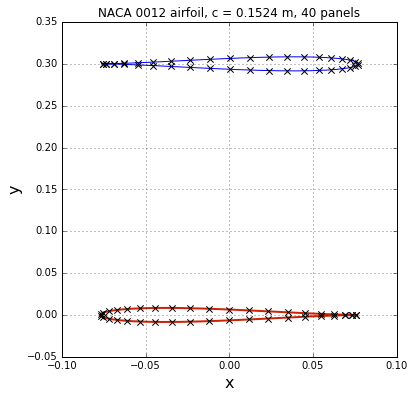

In [55]:
# plot NACA 0012 airfoil
N_panels = 40                    # number of panels desired

T = 0.12
H = 0
c = 0.1524  #[m] = 6 in
a = c/4
r = (0.25+T/(3*math.sqrt(3)))*c                      # circle radius
zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H        # circle center
zeta_c2 = -4*a/(3*numpy.sqrt(3))*T + 1j*2*a*H
theta = numpy.linspace(0, 2*math.pi, N_panels+1)   # theta endpoints of panels
zeta = r*numpy.exp(1j*theta)                       # endpoints of circle surface panels
zeta2 = r*numpy.exp(1j*theta)
z_ends = (zeta+zeta_c) + a**2/(zeta+zeta_c) # endpoints of airfoil surface panels
z_ends2 = (zeta2+zeta_c) + a**2/(zeta2+zeta_c)+0.3j    # add 1 ft offset from other airfoil
x_ends,  y_ends = z_ends.real, z_ends.imag
x_ends2, y_ends2 = -z_ends2.real, z_ends2.imag    #turn airfoil in other direction
#x_ends = numpy.delete(x_ends,[1,N_panels-1])       # delete 2nd and 2nd to last points to merge panels
#y_ends = numpy.delete(y_ends,[1,N_panels-1])
#N_panels = N_panels - 2

# define the panels
panels1a = numpy.empty(N_panels+1, dtype=object)
panels1b = numpy.empty(N_panels+1, dtype=object)
#panels = numpy.empty((len(rb),N_panels+1),dtype=(object,float))
#for j in range(len(rb)):
for i in range(N_panels):
    panels1a[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    panels1b[i] = Panel(x_ends2[i], y_ends2[i], x_ends2[i+1], y_ends2[i+1])
panels1a[-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])
panels1b[-1] = Panel(x_ends2[0], y_ends2[0], x_ends2[0]-1000, y_ends2[0])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.plot(x_ends2,y_ends2)
#pyplot.scatter([p.xa for p in panels1a], [p.ya for p in panels1a], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels1a], [p.yc for p in panels1a], color='k', marker='x', s=40, zorder=3)
pyplot.scatter([p.xc for p in panels1b], [p.yc for p in panels1b], color='k', marker='x', s=40, zorder=3)

#pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              #scale=15, width=0.005)
#pyplot.legend(['panels', 'end-points', 'center-points'], loc='best', prop={'size':16})
pyplot.xlim(-0.1, 0.1)
#pyplot.ylim(-0.1, 0.1)
pyplot.title('NACA 0012 airfoil, c = {} m, {} panels'.format(c,N_panels));

In [62]:
numpy.shape(panels1a)

(41,)

In [19]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

Since all of the airfoils are the same (NACA 0012 and same chord), the A matrix will be the same for each set of panels. However, since the freestream velocity, $V_{\infty}$, and angle of attack, $\alpha$, are different for each blade segment, we need to create our matrix $b$ such that it creates $N_segment$ of $b$ matrices.

<img src="files/bmatrix.jpg">
![Image](./figures/bmatrix.png)

In [20]:
# compute the influence coefficient matrix
def matrix_norm(N_panels,panels,V1,alpha):
    A = numpy.zeros((2*N_panels+2, 2*N_panels+2), dtype=float)

    for i, p_i in enumerate(panelsa[0:N_panels]):
        for j, p_j in enumerate(panelsa):
            if i == 0:N_panels and j == 0:N_panels:
                A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
            #if i == j:
                #A[i,j] *= 1.001
    for i, p_i in enumerate(panelsa[0:N_panels]):
        for j, p_j in enumerate(panelsb):
            if i == 0:N_panels and j == N_panels+1:-1:
                A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                
    for i, p_i in enumerate(panelsb[0:N_panels]):
        for j, p_j in enumerate(panelsa):
            if i == N_panels+1:-1 and j == 0:N_panels:
                A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                
    for i, p_i in enumerate(panelsb[0:N_panels]):
        for j, p_j in enumerate(panelsb):
            if i == N_panels+1:-1 and j == N_panels+1:-1:
                A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
                
    A[-1,0] = -1
    A[-1,-2] = 1
    A[-1,-1] = -1

    # compute the RHS of the linear system
    b = numpy.zeros((len(N_seg),2*N_panels+2, 1), dtype=float)
    #for r in range(len(alpha)):
    for s in range(len(N_seg)):
        for i, p_i in enumerate(panelsa[0:N_panels]):
            b[s,i,0] = -numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.n)
        for i, p_i in enumerate(panelsb[N_panels+2:-2]):
            b[s,i,0] = numpy.dot(numpy.array([V1[s]*math.cos(alpha[s]), V1[s]*math.sin(alpha[s])]), p_i.n)
        
    return A,b

In [64]:
2*N_panels+2

82

In [21]:
# solves the linear system
def find_kap(A,b,panels):
    kappa = numpy.linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.kappa = float(kappa[i])

In [13]:
def matrix_tang(panels,N_panels,V1,alpha):
    for i, p_i in enumerate(panels[0:N_panels]):
        vt = numpy.array([0])
        for j, p_j in enumerate(panels):
            if i != j:
                vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
        if i == 0:
            R = math.sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
            vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
        elif i == N_panels-1:
            R = math.sqrt((panels[N_panels-1].xc-panels[N_panels-2].xc)**2 + (panels[N_panels-1].yc-panels[N_panels-2].yc)**2)
            vt = vt - 0.5*(panels[N_panels-1].kappa-panels[N_panels-2].kappa)/R
        else:
            R = math.sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
            vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
        vt = vt + numpy.dot(numpy.array([V1[0]*math.cos(alpha[0]), V1[0]*math.sin(alpha[0])]), p_i.t)
        p_i.vt = float(vt)
        p_i.cp = 1.0 - (p_i.vt/V1[0])**2
        
        return vt

In [ ]:
# create surface of airfoil for analytical solution
thetaa = numpy.linspace(0.01, 2*math.pi-0.01, 41)      # theta coordinates
zeta = r*numpy.exp(1j*thetaa)                          # circle coordinates
z = (zeta+zeta_c) + a**2/(zeta+zeta_c)                # airfoil coordinates

# flow parameters
kappa = 2*math.pi*V1[0]*r**2                   # doublet strength for circle with radius r
Gam = 4*math.pi*r*V1[0]*numpy.sin(alpha[0]+2*H)      # vortex strength

# compute the complex velocity on the surface
w = V1[0] - kappa/(2*math.pi)/zeta**2 + 1j*Gam/(2*math.pi)/zeta
zeta = zeta*numpy.exp(1j*alpha[0])

# Joukowski transformation
w = w/(1 - a**2/(zeta+zeta_c)**2)
cp_analytical = 1 - numpy.abs(w)**2/V1[0]**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(z.real, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels[0:N_panels]], [p.cp for p in panels[0:N_panels]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
pyplot.xlim(-0.6, 0.6)
pyplot.ylim(-1, 1.5)
pyplot.gca().invert_yaxis();

In [ ]:
# integrate cp over blade

# Improvements

Improvements that could be made:
- input more complex blade shape
- correction factor for tip loss
- double rotor and effects that they will produce on each other


In [61]:
fart = numpy.zeros((N_seg,4,5),dtype=float)
fart[0,0,:] = 1
fart[4,:,:] = 7
print(fart)

[[[ 1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 7.  7.  7.  7.  7.]
  [ 7.  7.  7.  7.  7.]
  [ 7.  7.  7.  7.  7.]
  [ 7.  7.  7.  7.  7.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]
